In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
import re

In [2]:
train=pd.read_csv("C:\\Users\\NanduCn\\jupter1\\Sentiment.csv\\train_2kmZucJ.csv")
test=pd.read_csv("C:\\Users\\NanduCn\\jupter1\\Sentiment.csv\\test_oJQbWVk.csv")

In [3]:
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [4]:
train['tweet'].shape

(7920,)

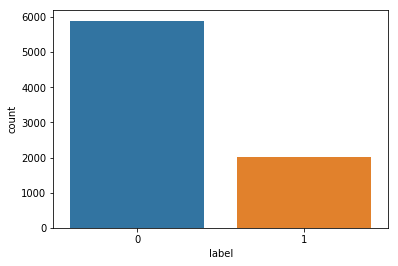

In [5]:
sns.countplot(train['label'])

In [6]:
train['text_length'] = train['tweet'].apply(len)
train[['label','text_length','tweet']].head()

,label,text_length,tweet
0,0,128,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,0,131,Finally a transparant silicon case ^^ Thanks t...
2,0,123,We love this! Would you go? #talk #makememorie...
3,0,112,I'm wired I know I'm George I was made that wa...
4,1,124,What amazing service! Apple won't even talk to...


In [7]:
train['text_length'].describe()

count    7920.000000
mean      128.920707
std        48.735818
min         7.000000
25%       106.000000
50%       124.000000
75%       131.000000
max       398.000000
Name: text_length, dtype: float64

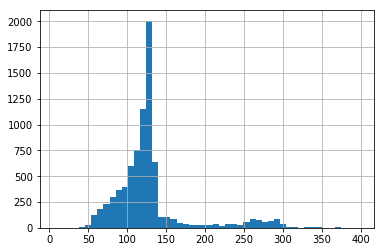

In [8]:
train['text_length'].hist(bins=50)

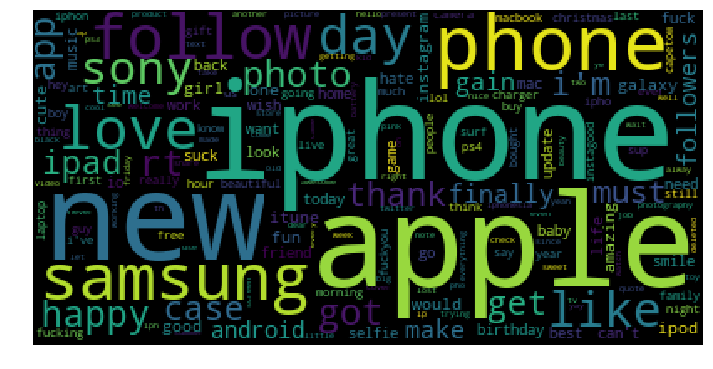

In [10]:
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    return s
train['clean_tweet'] = train['tweet'].apply(clean_text)

text = train['clean_tweet'].to_string().lower()    
wordcloud = WordCloud(
    collocations=False,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('english'))).generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

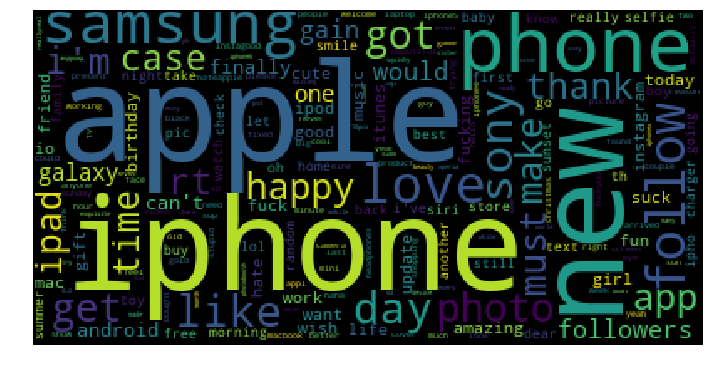

In [32]:
def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    return s
test['clean_tweet'] = test['tweet'].apply(clean_text)

text = test['clean_tweet'].to_string().lower()    
wordcloud = WordCloud(
    collocations=False,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('english'))).generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [12]:
X = train['clean_tweet']
y = pd.get_dummies(train['label']).values
num_classes = train['label'].nunique()
y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [13]:
seed = 101 # fix random seed for reproducibility
np.random.seed(seed)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6336,) (1584,) (6336, 2) (1584, 2)


In [15]:
from keras.preprocessing.text import Tokenizer
max_features = 3000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Using TensorFlow backend.


In [34]:
max_features = 3000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(test['clean_tweet']))
test_tw = tokenizer.texts_to_sequences(test['clean_tweet'])


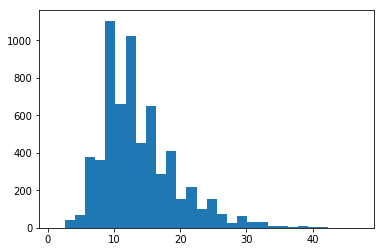

In [16]:
totalNumWords = [len(one_comment) for one_comment in X_train]
plt.hist(totalNumWords,bins = 30)
plt.show()

In [17]:
from keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(6336, 30) (1584, 30)


In [37]:
test_text=sequence.pad_sequences(test_tw, maxlen=max_words)

In [18]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 64
epochs = 5

In [26]:
max_features = 3000
embed_dim = 100

In [52]:
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))    
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           300000    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 30, 32)            9632      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 15, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 15, 32)            3104      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total para

In [53]:
 model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)
    

Train on 6336 samples, validate on 1584 samples
Epoch 1/5
 - 3s - loss: 0.4524 - acc: 0.7789 - val_loss: 0.2558 - val_acc: 0.8857
Epoch 2/5
 - 2s - loss: 0.2293 - acc: 0.9038 - val_loss: 0.2429 - val_acc: 0.8965
Epoch 3/5
 - 2s - loss: 0.1716 - acc: 0.9301 - val_loss: 0.2554 - val_acc: 0.8946
Epoch 4/5
 - 2s - loss: 0.1266 - acc: 0.9545 - val_loss: 0.3173 - val_acc: 0.8939
Epoch 5/5
 - 2s - loss: 0.0965 - acc: 0.9668 - val_loss: 0.3607 - val_acc: 0.8842


In [60]:
from sklearn import metrics

pred_noemb_val_y = model.predict([X_test], batch_size=1024, verbose=1)
for thresh in np.arange(0.1,  0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_test, (pred_noemb_val_y>thresh).astype(int))))

1584/1584 [==============================] - 0s 113us/step


In [61]:
pred=model.predict(test_text)

In [62]:
pred

array([[9.8852485e-01, 1.2272478e-02],
       [2.0172775e-01, 7.9672104e-01],
       [9.9984574e-01, 1.9831897e-04],
       ...,
       [9.9975568e-01, 2.7671875e-04],
       [9.9995482e-01, 7.9461468e-05],
       [9.9069756e-01, 8.8762119e-03]], dtype=float32)

In [63]:
sub=pd.read_csv("C:\\Users\\NanduCn\\jupter1\\Sentiment.csv\\sample_submission_LnhVWA4.csv")

In [64]:
sub.head()

,id,label
0,7921,0
1,7922,0
2,7923,0
3,7924,0
4,7925,0


In [65]:
test_pred_int = pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int

In [69]:
sub["id"]=test["id"]
sub['label']=test['label']

In [70]:
sub.to_csv("LStM.csv", index=False)

In [71]:
sub.head()

,id,label
0,7921,0.988525
1,7922,0.201728
2,7923,0.999846
3,7924,0.942127
4,7925,0.990634


In [50]:
from IPython.display import HTML
import base64  

import pandas as pd  

def create_download_link(sub, title = "Download CSV file", filename = "lstm.csv"):  
    csv = sub.to_csv(index =False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(sub)